In [6]:
from __future__ import annotations # https://stackoverflow.com/questions/42845972/typed-python-using-the-classes-own-type-inside-class-definition

In [33]:
from typing import Union, Tuple, Set
from collections import deque
from graphviz import Digraph
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
class Value:
  def __init__(self, 
               data:float, 
               parents:Tuple[Value] = (),
               op:str = "", label:str = ""):
    self.data = data
    self.parents = set(parents)
    self.cp_grads = lambda: None
    self.grad = 0
    self.op = op
    self.label = label
    
  def backward(self):
    topo_sort: list[Value] = []
    visited: set[Value] = set()
    to_visit: deque[Value] = deque([self])
    while(to_visit):
        current = to_visit.popleft()
        if current not in visited:
            topo_sort.append(current)
            to_visit.extend(current.parents)
            visited.add(current)
            
    self.grad = 1
    for value in topo_sort:
      value.cp_grads()
    
    
  def __add__(self, other: Union[Value, float]):
    other = other if type(other) == Value else Value(other)
    out = Value(self.data + other.data, (self, other), "+")
    
    def cp_grads():
      self.grad += out.grad * 1.0
      other.grad += out.grad * 1.0
    out.cp_grads = cp_grads
    
    return out
  
  def __mul__(self, other: Union[Value, float]):
    other = other if type(other) == Value else Value(other)
    out = Value(self.data * other.data, (self, other), "*")
    
    def cp_grads():
      self.grad = out.grad * other.data
      other.grad = out.grad * self.data
    out.cp_grads = cp_grads
    
    return out
  
  def __radd__(self, other):
    return self.__add__(other)
  
  def __rmul__(self, other):
    return self.__mul__(other)
  
  def __repr__(self) -> str:
    return f"Value(data={self.data}, label={self.label})"

In [35]:
def trace(root: Value):
    nodes: Set[Value] = set()
    edges: Set[Value] = set()
    def build(node: Value):
        if node not in nodes:
            nodes.add(node)
        for parent in node.parents:
            edges.add((parent, node))
            build(parent)
    build(root)
    return nodes, edges

def draw_graph(root: Value):
    graph = Digraph(format="svg", graph_attr={"rankdir": "LR"})
    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))
        graph.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (node.label, node.data, node.grad), shape="record")
        if node.op:
            graph.node(name=f"{uid}-{node.op}", label=node.op)
            graph.edge(f"{uid}-{node.op}", uid)
    for (n1, n2) in edges:
        graph.edge(str(id(n1)), f"{str(id(n2))}-{n2.op}")
        
    return graph

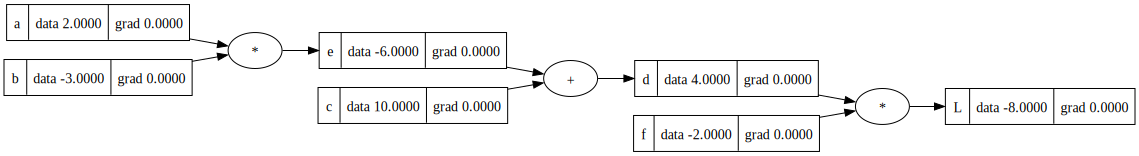

In [41]:
a = Value(2, label="a")
b = Value(-3, label="b")
c = Value(10, label="c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label="f")
L = d * f; L.label = "L"
draw_graph(L)

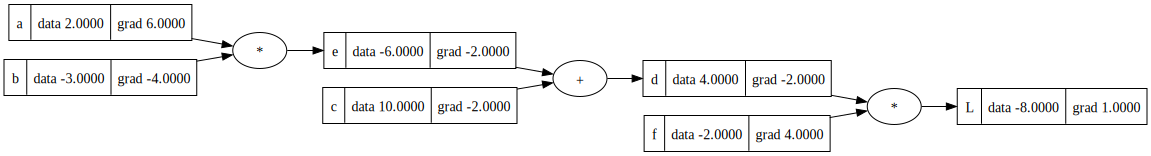

In [42]:
L.backward()
draw_graph(L)

In [23]:
topo_sort

[Value(data=-8.0, label=L),
 Value(data=-2.0, label=f),
 Value(data=4, label=d),
 Value(data=10, label=c),
 Value(data=-6, label=e),
 Value(data=-3, label=b),
 Value(data=2, label=a)]

In [62]:
c.backward()
a.grad, b.grad, c.grad

(0, 0, 0)